### Fourier Transform 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
from numpy import fft 
from core.core import *
import random
import os 


## Search method practice

### 1. Symbol-to-Symbol Detection

[ 1.-1.j  1.-1.j  1.-1.j  1.-1.j  1.-1.j  1.-1.j -1.+1.j -1.-1.j  1.-1.j
 -1.+1.j]
0 (0.20986987842973193-1.4795015791841633j)
1 (0.3593925790623726-1.7619911584602281j)
2 (0.2575139209153072-1.6711949739558891j)
3 (1.4191220393824016-1.5367479000042537j)
4 (0.7904230988433584-0.2276222520302589j)
5 (3.4470579741909066-1.1266522954618983j)
6 (-0.7740937419723104+1.4231377229599083j)
7 (-0.278152389748804-0.3353098344609622j)
8 (0.13235874599295008-0.9296807413864445j)
9 (-0.6050296234222297+0.22838779389502414j)


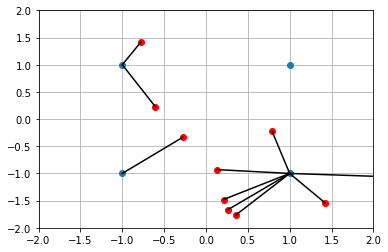

In [2]:
x_r = np.random.randn(10)
x_i = np.random.randn(10) 
x = x_r + 1j * x_i 
cp_r = []

cpoints = np.array([
    -1-1j,
    -1+1j, 
    1+1j,
    1-1j,
])
plt.plot(cpoints.real, cpoints.imag, 'o')
plt.plot(x_r, x_i, 'or')

compare = np.abs(x - cpoints.reshape(-1, 1))
dets = np.array([cpoints[i] for i in np.argmin(compare, axis=0)])
print(dets)

for i, cp in enumerate(x):
    print(i, cp) 
    plt.plot([dets[i].real, cp.real], [dets[i].imag, cp.imag], 'k-')

plt.grid() 
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.show()


In [3]:
c = 2
x_estimated = x
x_detected = dets 
x_exact = cpoints.reshape(-1, 1)
x_estimated, x_detected, x_exact 

(array([ 0.20986988-1.47950158j,  0.35939258-1.76199116j,
         0.25751392-1.67119497j,  1.41912204-1.5367479j ,
         0.7904231 -0.22762225j,  3.44705797-1.1266523j ,
        -0.77409374+1.42313772j, -0.27815239-0.33530983j,
         0.13235875-0.92968074j, -0.60502962+0.22838779j]),
 array([ 1.-1.j,  1.-1.j,  1.-1.j,  1.-1.j,  1.-1.j,  1.-1.j, -1.+1.j,
        -1.-1.j,  1.-1.j, -1.+1.j]),
 array([[-1.-1.j],
        [-1.+1.j],
        [ 1.+1.j],
        [ 1.-1.j]]))

In [4]:
nominator = np.abs(x_estimated - x_exact)
denominator = np.abs(x_estimated - x_detected)

In [6]:
print(nominator)
print(denominator)
condition = nominator / denominator < c

[[2.22791516 1.45220947 3.04136682 1.8146555  0.6393695  2.4570137
  1.61871597 1.32239311 3.12404502 1.18768184]
 [3.26444445 2.74409179 3.59266833 0.98146412 1.46318195 3.57205435
  2.36878472 0.67795955 1.12405515 1.94501035]
 [2.43047889 2.42852275 2.17867501 1.18762882 2.22683669 2.70484235
  1.79315201 2.09487841 2.29942446 1.82203666]
 [0.46285635 0.69035887 1.04368157 1.93395061 1.79629998 0.77040003
  0.47380846 2.38277358 3.71261501 0.97331418]]
[0.46285635 0.69035887 1.04368157 0.98146412 0.6393695  0.77040003
 0.47380846 0.67795955 1.12405515 0.97331418]


In [7]:
# search nML 

print(np.sum(condition.T, axis=1))
nnset = np.array(np.nonzero(condition.T))
# np.array([cpoints[i] for i in np.nonzero(condition.T)[1]])

nn = [[] for _ in range(10)]
for k, m in nnset.T:

    nn[k].append(m) 
print(nn)
new = []
for n in nn:
    new.append(list(np.take(cpoints, n)))
new

[1 1 1 4 1 1 1 2 1 4]
[[3], [3], [3], [0, 1, 2, 3], [0], [3], [3], [0, 1], [1], [0, 1, 2, 3]]


[[(1-1j)],
 [(1-1j)],
 [(1-1j)],
 [(-1-1j), (-1+1j), (1+1j), (1-1j)],
 [(-1-1j)],
 [(1-1j)],
 [(1-1j)],
 [(-1-1j), (-1+1j)],
 [(-1+1j)],
 [(-1-1j), (-1+1j), (1+1j), (1-1j)]]

## MIMO Receiver with 1-bit-ADC (Linear Receiver) for 1 timestep

In [496]:
K = 2
N = 16
M = 4 


def make_symbol_space(K, M, cp):
    index_space = np.indices([M for _ in range(K)]).reshape(K, -1).T 
    symbol_space = np.take(cp, index_space)
    symbol_space = np.hstack((symbol_space.real, symbol_space.imag))
    return symbol_space 

def comp2re(H, x, z, y):
    x_re = np.vstack((x.real, x.imag))
    z_re = np.vstack((z.real, x.imag))
    y_re = np.vstack((y.real, y.imag)) 
    H_re = np.block([
        [H.real, -H.imag],
        [H.imag, H.real]
    ])
    return H_re, x_re, z_re, y_re 

# ML detection of single timestep
def ml_detection(y_re, H_re, symbol_space, snr_dB):
    snr = (10**(snr_dB/20))
    return symbol_space[np.argmax(np.sum(np.log(phi((np.matmul(symbol_space, H_re.T) * y_re.T) * np.sqrt(2 * snr))), axis=1))].reshape(-1, 1)

# simple constellation points (normalized)
constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
constellation_points /= np.sqrt(2) 
symbol_space = make_symbol_space(K, M, cp=constellation_points) 

snr = -5

# symbols for 1-timeslot 
x = np.random.randint(0, M, size=K).reshape(-1, 1) 
x = np.take(constellation_points, x)

# Channel 
H = (1 / np.sqrt(2)) * (np.random.randn(N, K) + 1j * np.random.randn(N, K))
z = (1 / np.sqrt(2)) * (np.random.randn(N, 1) + 1j * np.random.randn(N, 1))

r = np.matmul(H, x) + (10**(-snr/20)) * z 

# 1-bit ADC 
y = np.sign(r.real) + 1j * np.sign(r.imag) 

H_re, x_re, z_re, y_re = comp2re(H, x, z, y)

# # relaxed linear receiver 
# W_zf = np.linalg.pinv(H_re)
# W_MMSE = np.matmul((H_re.conjugate()).T, H_re) + np.eye(2 * K) 
# W_MMSE = np.linalg.inv(W_MMSE) 
# W_MMSE = np.matmul(W_MMSE, (H_re.conjugate()).T)

# # Relaxed estimation of x  
# x_tilde_zf = np.matmul(W_zf, y) 
# x_tilde_mmse = np.matmul(W_MMSE, y) 


# # real to complex representation to detect symbol
# x_tilde_zf = x_tilde_zf[:K] + 1j * x_tilde_zf[K:]
# x_tilde_mmse = x_tilde_mmse[:K] + 1j * x_tilde_mmse[K:]

# # detection within each users (symbol-by-symbol)
# compare = np.abs(x_tilde_zf - constellation_points)
# det_by_idx = np.argmin(compare, axis=1) 
# x_hat_zf = np.take(constellation_points, det_by_idx).reshape(x_tilde_zf.shape)

# compare = np.abs(x_tilde_mmse - constellation_points)
# det_by_idx = np.argmin(compare, axis=1) 
# x_hat_mmse = np.take(constellation_points, det_by_idx).reshape(x_tilde_mmse.shape) 

# # Compare 
# np.isclose(x, x_hat_zf), np.isclose(x, x_hat_mmse)


# ML detection (1-timestep) 
x_hat_ML = ml_detection(y_re=y_re, H_re=H_re, symbol_space=symbol_space, snr_dB=snr)

np.isclose(x_re, x_hat_ML)


array([[ True],
       [ True],
       [ True],
       [ True]])

In [106]:
# ML detection of single timestep
def ml_detection(y_re, H_re, symbol_space, snr_dB):
    snr = (10**(snr_dB/20))
    return symbol_space[np.argmax(np.sum(np.log(phi((np.matmul(symbol_space, H_re.T) * y_re.T) * np.sqrt(2 * snr))), axis=1))].reshape(-1, 1)

## MIMO receiver with 1-bit-ADC (Linear Receiver) with N time transmission 

snr:  -10 ser: 0.3165205
snr:  -5 ser: 0.10916599999999999


/var/folders/qf/g6m74fsx51j_2q1__9zjd_5m0000gn/T/ipykernel_1275/1487939172.py:39: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(likelihood), axis=2)


snr:  0 ser: 0.013920000000000043
snr:  5 ser: 0.0009135000000000115
snr:  10 ser: 7.999999999996898e-05
snr:  15 ser: 1.7000000000044757e-05
snr:  20 ser: 4.499999999962867e-06
snr:  25 ser: 1.4999999999876223e-06
snr:  30 ser: 4.999999999588667e-07


ValueError: x and y must have same first dimension, but have shapes (40,) and (9,)

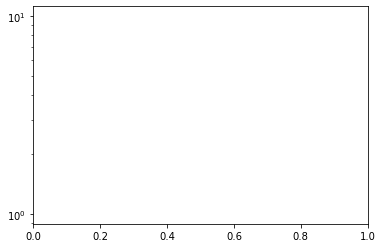

In [15]:
from matplotlib.markers import MarkerStyle


K = 2   # Number of users (transmitter antenna) 
N = 16   # Number of Receiver (Receive antenna)
M = 4   # level of modulation (4-QAM / QPSK)
T = int(1e6) # Total Transmission rounds 
SNR_max = 30


def make_symbol_space(K, M, cp):
    """
    Makes symbol space S = |M|^K 
    :params: 
    :   K (int) : number of users\n
    :   M (int) : level of modulation\n
    :returns:
    :   symbol_space (np.ndarray) : symbol space S=|M|^K
    """
    index_space = np.indices([M for _ in range(K)]).reshape(K, -1).T 
    symbol_space = np.take(cp, index_space)
    return symbol_space 

def comp2re(H, x, z, y):
    x_re = np.hstack((x.real, x.imag))
    z_re = np.hstack((z.real, x.imag))
    y_re = np.hstack((y.real, y.imag)) 
    H_re = np.block([
        [H.real, -H.imag],
        [H.imag, H.real]
    ])
    return H_re, x_re, z_re, y_re 

def ml_detection(y_re, H_re, symbol_space, snr_dB):
    # complex to real and then reshape for broadcast
    snr = 10**(snr_dB/20)
    symbol_space_re = np.hstack((symbol_space.real, symbol_space.imag)) * np.ones(shape=(T, M**K, 2*K))
    likelihood = phi(np.matmul(symbol_space_re, H_re.transpose(0, 2, 1)) * y_re.transpose(0, 2, 1) * np.sqrt(2 * snr))
    log_likelihood = np.sum(np.log(likelihood), axis=2)
    x_hat_idx = np.argmax(log_likelihood, axis=1)
    x_hat_ML = np.take(symbol_space, x_hat_idx, axis=0)
    x_hat_ML = x_hat_ML.reshape(x.shape)
    return x_hat_ML 

# simple constellation points (normalized)
constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
constellation_points /= np.sqrt(2) 

# make symbol space = |M|^K  in case of using ML detection 
symbol_space = make_symbol_space(K, M, cp=constellation_points) 
sers = []
sers_mmse = []
for snr in np.arange(-10, SNR_max+1, 5):
    # symbols for T timeslots
    x = np.random.randint(0, M, size=K * T).reshape(T, K, 1) 
    x = np.take(constellation_points, x)

    # Channel 
    H = (1 / np.sqrt(2)) * (np.random.randn(T, N, K) + 1j * np.random.randn(T, N, K))
    z = (1 / np.sqrt(2)) * (np.random.randn(T, N, 1) + 1j * np.random.randn(T, N, 1))

    r = np.matmul(H, x) + (10**(-snr/20)) * z  

    # 1-bit ADC 
    y = np.sign(r.real) + 1j * np.sign(r.imag) 

    H_re, x_re, z_re, y_re = comp2re(H, x, z, y) 

    x_hat_ML = ml_detection(y_re=y_re, H_re=H_re, symbol_space=symbol_space, snr_dB=snr)

    ser = 1 - np.sum(np.isclose(x, x_hat_ML)) / (T * K) 
    sers.append(ser)

    # # relaxed linear receiver 
    # W_zf = np.linalg.pinv(H)
    # W_mmse = np.matmul((H.conjugate()).transpose((0, 2, 1)), H) + (10**(-snr/20))*((np.eye(K)+1j*np.eye(K)) * np.ones((T, K, K)))
    # W_mmse = np.linalg.inv(W_mmse)
    # W_mmse = np.matmul(W_mmse, (H.conjugate()).transpose((0, 2, 1)))

    # # Relaxed estimation of x  
    # x_tilde = np.matmul(W_zf, y)
    # x_tilde_mmse = np.matmul(W_mmse, y)
        

    # # detection within each users (symbol-by-symbol)
    # compare = np.abs(x_tilde - constellation_points)
    # det_by_idx = np.argmin(compare, axis=-1) 
    # x_hat = np.take(constellation_points, det_by_idx).reshape(x_tilde.shape)

    # compare = np.abs(x_tilde_mmse - constellation_points)
    # det_by_idx = np.argmin(compare, axis=-1)
    # x_hat_mmse = np.take(constellation_points, det_by_idx).reshape(x_tilde_mmse.shape) 

    # # Compare 
    # ser = 1-np.sum(np.isclose(x, x_hat)) / (T * K)
    # ser_mmse = 1-np.sum(np.isclose(x, x_hat_mmse)) / (T*K)

    # if snr % 5 == 0:
        # print("snr: ", snr, "ser (zf): ", ser, "     |     ser(mmse): ", ser_mmse)
    # print("snr: ", snr, "ser:", ser)
    # sers.append(ser)
    # sers_mmse.append(ser_mmse)



plt.figure()
plt.semilogy(np.arange(-10, SNR_max+1, 5), sers, '-b*', linewidth=1, label='ZF') 
# plt.semilogy(sers_mmse, '--bo', linewidth=1, label='MMSE')
plt.xticks(np.arange(-10, 31, 5))
plt.grid() 
plt.legend()
plt.show()


ValueError: x and y must have same first dimension, but have shapes (9,) and (8,)

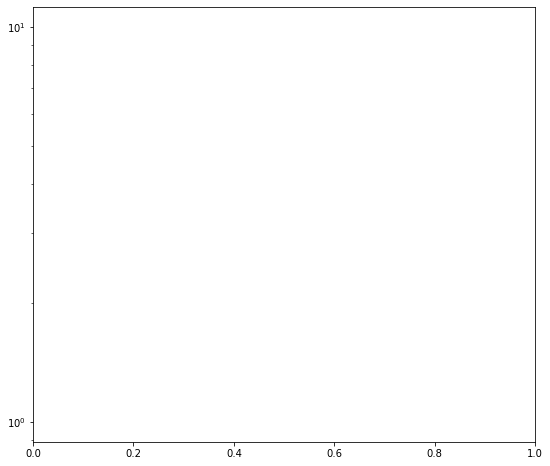

In [22]:
plt.figure(figsize=(9, 8))
plt.semilogy(np.arange(-10, SNR_max+1, 5), sers, '-bo', linewidth=1, label='conventional-ML', fillstyle='none') 
# plt.semilogy(sers_mmse, '--bo', linewidth=1, label='MMSE')
plt.yticks([1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7])
plt.grid() 
plt.legend()
plt.show()

In [566]:
# symbol_space_re = np.hstack((symbol_space.real, symbol_space.imag)) * np.ones(shape=(T, M**K, 2*K))
# snr_dB = 10
# snr = (10 ** (snr_dB/20))
# likelihood = phi(np.matmul(symbol_space_re, H_re.transpose(0, 2, 1)) * y_re.transpose(0, 2, 1) * np.sqrt(2 * snr))
# log_likelihood = np.sum(np.log(likelihood), axis=2)
# x_hat_idx = np.argmax(log_likelihood, axis=1)
# x_hat_ML = np.take(symbol_space, x_hat_idx, axis=0)
# x_hat_ML = x_hat_ML.reshape(x.shape)

# print(np.sum(np.isclose(x_hat_ML, x)))

def ml_detection(y_re, H_re, symbol_space, snr_dB):
    symbol_space_re = np.hstack((symbol_space.real, symbol_space.imag)) * np.ones(shape=(T, M**K, 2*K))
    likelihood = phi(np.matmul(symbol_space_re, H_re.transpose(0, 2, 1)) * y_re.transpose(0, 2, 1) * np.sqrt(2 * snr))
    log_likelihood = np.sum(np.log(likelihood), axis=2)
    x_hat_idx = np.argmax(log_likelihood, axis=1)
    x_hat_ML = np.take(symbol_space, x_hat_idx, axis=0)
    x_hat_ML = x_hat_ML.reshape(x.shape)
    return x_hat_ML 
x_hat_ML = ml_detection(y_re, H_re=H_re, symbol_space=symbol_space, snr_dB=30)
np.sum(np.isclose(x_hat_ML, x))

/Users/lab2020/opt/anaconda3/envs/learning/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


200

In [549]:
np.take(symbol_space, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0], axis=0)

array([[-0.70710678-0.70710678j, -0.70710678+0.70710678j],
       [-0.70710678-0.70710678j,  0.70710678-0.70710678j],
       [-0.70710678-0.70710678j,  0.70710678+0.70710678j],
       [-0.70710678+0.70710678j, -0.70710678-0.70710678j],
       [-0.70710678+0.70710678j, -0.70710678+0.70710678j],
       [-0.70710678+0.70710678j,  0.70710678-0.70710678j],
       [-0.70710678+0.70710678j,  0.70710678+0.70710678j],
       [ 0.70710678-0.70710678j, -0.70710678-0.70710678j],
       [ 0.70710678-0.70710678j, -0.70710678+0.70710678j],
       [ 0.70710678-0.70710678j,  0.70710678-0.70710678j],
       [ 0.70710678-0.70710678j,  0.70710678+0.70710678j],
       [ 0.70710678+0.70710678j, -0.70710678-0.70710678j],
       [ 0.70710678+0.70710678j, -0.70710678+0.70710678j],
       [ 0.70710678+0.70710678j,  0.70710678-0.70710678j],
       [ 0.70710678+0.70710678j,  0.70710678+0.70710678j],
       [-0.70710678-0.70710678j, -0.70710678-0.70710678j]])

In [540]:
# ML detection of single timestep
def ml_detection(y_re, H_re, symbol_space, snr_dB):
    snr = (10**(snr_dB/20))
    return symbol_space[np.argmax(np.sum(np.log(phi((np.matmul(symbol_space, H_re.T) * y_re.T) * np.sqrt(2 * snr))), axis=1))].reshape(-1, 1)

## MIMO receiver with 1-bit-ADC (Linear Receiver) with N time transmission 
### monte-carlo simulation

____________________________________________________________________________________________________
trial :  0
snr:  -10 ser(ML): 3.165e-01   |  ser(zf): 3.154e-01    |   ser(mmse): 3.251e-01
snr:  -5 ser(ML): 1.091e-01   |  ser(zf): 1.154e-01    |   ser(mmse): 1.200e-01
snr:  0 ser(ML): 1.402e-02   |  ser(zf): 1.870e-02    |   ser(mmse): 2.026e-02


/var/folders/qf/g6m74fsx51j_2q1__9zjd_5m0000gn/T/ipykernel_1275/1487939172.py:39: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(likelihood), axis=2)


snr:  5 ser(ML): 8.250e-04   |  ser(zf): 2.420e-03    |   ser(mmse): 2.585e-03
snr:  10 ser(ML): 6.000e-05   |  ser(zf): 8.150e-04    |   ser(mmse): 8.050e-04
snr:  15 ser(ML): 1.000e-05   |  ser(zf): 5.700e-04    |   ser(mmse): 5.550e-04
snr:  20 ser(ML): 0.000e+00   |  ser(zf): 4.700e-04    |   ser(mmse): 4.350e-04
snr:  25 ser(ML): 0.000e+00   |  ser(zf): 3.350e-04    |   ser(mmse): 3.300e-04
____________________________________________________________________________________________________
trial :  1
snr:  -10 ser(ML): 3.145e-01   |  ser(zf): 3.142e-01    |   ser(mmse): 3.230e-01
snr:  -5 ser(ML): 1.094e-01   |  ser(zf): 1.149e-01    |   ser(mmse): 1.206e-01
snr:  0 ser(ML): 1.353e-02   |  ser(zf): 1.825e-02    |   ser(mmse): 1.946e-02
snr:  5 ser(ML): 8.400e-04   |  ser(zf): 2.525e-03    |   ser(mmse): 2.645e-03
snr:  10 ser(ML): 6.500e-05   |  ser(zf): 7.900e-04    |   ser(mmse): 7.850e-04
snr:  15 ser(ML): 5.000e-06   |  ser(zf): 5.300e-04    |   ser(mmse): 4.800e-04
snr:  20 s

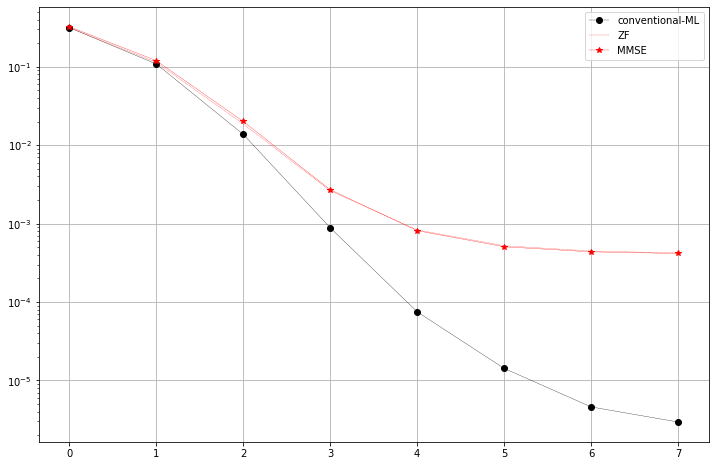

In [21]:
K = 2   # Number of users (transmitter antenna) 
N = 16   # Number of Receiver (Receive antenna)
M = 4   # level of modulation (4-QAM / QPSK)
T = int(1e5) # Total Transmission rounds 
SNR_max = 30


def make_symbol_space(K, M, cp):
    """
    Makes symbol space S = |M|^K 
    :params: 
    :   K (int) : number of users\n
    :   M (int) : level of modulation\n
    :returns:
    :   symbol_space (np.ndarray) : symbol space S=|M|^K
    """
    index_space = np.indices([M for _ in range(K)]).reshape(K, -1).T 
    symbol_space = np.take(cp, index_space)
    return symbol_space 

def comp2re(H, x, z, r):
    x_re = np.hstack((x.real, x.imag))
    z_re = np.hstack((z.real, x.imag))
    r_re = np.hstack((r.real, r.imag)) 
    H_re = np.block([
        [H.real, -H.imag],
        [H.imag, H.real]
    ])
    return H_re, x_re, z_re, r_re 

# simple constellation points (normalized)
constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
constellation_points /= np.sqrt(2) 

snr_lst = np.arange(-10, SNR_max, 5)
# make symbol space = |M|^K  in case of using ML detection 
symbol_space = make_symbol_space(K, M, cp=constellation_points) 
sers_avg = np.zeros_like(snr_lst, dtype=np.float64)
sers_avg_zf = np.zeros_like(snr_lst, dtype=np.float64)
sers_avg_mmse = np.zeros_like(snr_lst, dtype=np.float64)
trials = 100
for t in range(trials):
    sers = []
    sers_zf = []
    sers_mmse = []
    print("_" * 100) 
    print("trial : ", t)
    for snr in snr_lst:
        # symbols for T timeslots
        x = np.random.randint(0, M, size=K * T).reshape(T, K, 1) 
        x = np.take(constellation_points, x)

        # Channel 
        H = (1 / np.sqrt(2)) * (np.random.randn(T, N, K) + 1j * np.random.randn(T, N, K))
        z = (1 / np.sqrt(2)) * (np.random.randn(T, N, 1) + 1j * np.random.randn(T, N, 1))

        r = np.matmul(H, x) + (10**(-snr/20)) * z 
        y = np.sign(r.real) + 1j * np.sign(r.imag) 

        H_re, x_re, z_re, y_re = comp2re(H, x, z, y) 

        x_hat_ML = ml_detection(y_re=y_re, H_re=H_re, symbol_space=symbol_space, snr_dB=snr)



        # relaxed linear receiver 
        W_zf = np.linalg.pinv(H)
        W_MMSE = np.matmul((H.conjugate()).transpose(0, 2, 1), H) + (10 ** (-snr/20)) * ((np.eye(K) + 1j * np.eye(K)) * np.ones(shape=(T, K, K)))
        W_MMSE = np.linalg.inv(W_MMSE) 
        W_MMSE = np.matmul(W_MMSE, (H.conjugate()).transpose(0, 2, 1))

        # Relaxed estimation of x  
        x_tilde_zf = np.matmul(W_zf, y)
        x_tilde_mmse = np.matmul(W_MMSE, y) 

        # detection within each users (symbol-by-symbol)
        compare = np.abs(x_tilde_zf - constellation_points)
        det_by_idx = np.argmin(compare, axis=-1) 
        x_hat_zf = np.take(constellation_points, det_by_idx).reshape(x_tilde_zf.shape)

        compare = np.abs(x_tilde_mmse - constellation_points)
        det_by_idx = np.argmin(compare, axis=-1) 
        x_hat_mmse = np.take(constellation_points, det_by_idx).reshape(x_tilde_mmse.shape) 

        # Compare 
        ser = 1 - np.sum(np.isclose(x, x_hat_ML)) / (T * K) 
        ser_zf = 1-np.sum(np.isclose(x, x_hat_zf)) / (T * K)
        ser_mmse = 1-np.sum(np.isclose(x, x_hat_mmse)) / (T * K)

        if snr % 5 == 0:
            print(f"snr: ", snr, f"ser(ML): {ser:.3e}", f"  |  ser(zf): {ser_zf:.3e}", f"   |   ser(mmse): {ser_mmse:.3e}")
        sers.append(ser)
        sers_zf.append(ser_zf)
        sers_mmse.append(ser_mmse) 
    sers_avg += np.array(sers)
    sers_avg_zf += np.array(sers_zf)
    sers_avg_mmse += np.array(sers_mmse)
sers_avg /= trials
sers_avg_zf /= trials
sers_avg_mmse /= trials

plt.figure(figsize=(12, 8))
plt.semilogy(sers_avg, '-ko', linewidth=0.3, label='conventional-ML')
plt.semilogy(sers_avg_zf, '--r', linewidth=0.3, label='ZF')
plt.semilogy(sers_avg_mmse, '-r*', linewidth=0.3, label='MMSE') 
plt.grid()
plt.legend()
plt.show()





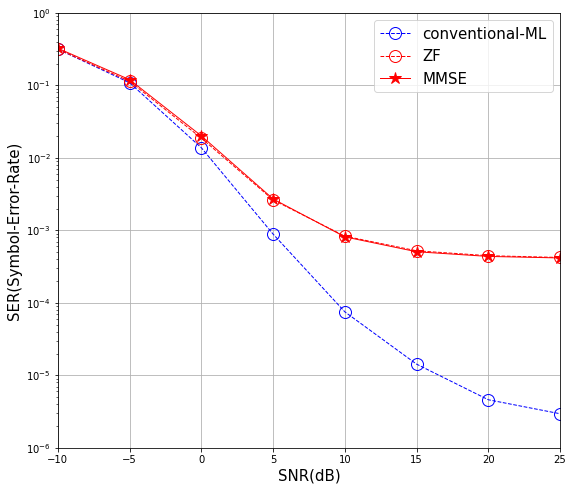

In [35]:

plt.figure(figsize=(9, 8))
plt.semilogy(snr_lst, sers_avg, '--bo', linewidth=1, label='conventional-ML', fillstyle='none', markersize=12)
plt.semilogy(snr_lst, sers_avg_zf, '--ro', linewidth=1, label='ZF', fillstyle='none', markersize=12)
plt.semilogy(snr_lst, sers_avg_mmse, '-r*', linewidth=1, label='MMSE', markersize=12) 
plt.yticks([1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
plt.xlim([-10, 25])
plt.xlabel("SNR(dB)", fontsize=15)
plt.ylabel("SER(Symbol-Error-Rate)", fontsize=15)
plt.grid()
plt.legend(fontsize=15)
plt.show()

## Bussgang receiver

In [99]:
def make_symbol_space(K, M, cp):
    """
    Makes symbol space S = |M|^K 
    :params: 
    :   K (int) : number of users\n
    :   M (int) : level of modulation\n
    :returns:
    :   symbol_space (np.ndarray) : symbol space S=|M|^K
    """
    index_space = np.indices([M for _ in range(K)]).reshape(K, -1).T 
    symbol_space = np.take(cp, index_space)
    return symbol_space 

def comp2re(H, x, z, r):
    x_re = np.hstack((x.real, x.imag))
    z_re = np.hstack((z.real, x.imag))
    r_re = np.hstack((r.real, r.imag)) 
    H_re = np.block([
        [H.real, -H.imag],
        [H.imag, H.real]
    ])
    return H_re, x_re, z_re, r_re 

def symbol_by_symbol(x_tilde, constellation_points):
    compare = np.abs(x_tilde - constellation_points)
    det_by_idx = np.argmin(compare, axis=-1) 
    x_hat = np.take(constellation_points, det_by_idx).reshape(x_tilde.shape)
    return x_hat 

def covr(H, snr):
    global N
    global T 
    if len(H.shape)>2:
        # return np.matmul(H, (H.conjugate()).transpose(0, 2, 1)) + (10 ** (-snr/20)) * (np.eye(N) + 1j * np.eye(N)) * np.ones(shape=(T, N, N))
        return np.matmul(H, (H.conjugate()).transpose(0, 2, 1)) + (10 ** (-snr/20)) * (np.eye(N)) * np.ones(shape=(T, N, N))
    else:
        return np.matmul(H, (H.conjugate()).T) + (10**(-snr/20))*(np.eye(N) + 1j * np.eye(N)) 

def bussgang(H, snr):
    global N 
    Sigma_r = covr(H, snr)        # Sigma_r 
    diag_sigma = Sigma_r * ((np.eye(N)) * np.ones(shape=(T, N, N)))
    inv_diag_sigma = np.linalg.inv(diag_sigma) 
    sqrt_diag_sigma = np.sqrt(inv_diag_sigma)
    V = sqrt_diag_sigma * np.sqrt(2 / np.pi) 
    effective_channel = np.matmul(V, H) 

    ls = np.matmul(sqrt_diag_sigma, Sigma_r)
    rs1 = np.matmul(ls, sqrt_diag_sigma) * 0.9999
    ls = np.arcsin(rs1.real) + 1j * np.arcsin(rs1.imag)

    rs = rs1 - (10 ** (-snr / 20)) * np.linalg.inv(diag_sigma)
    effective_noise_covariance = np.sqrt(2 / np.pi) * (ls - rs)
    return effective_channel, effective_noise_covariance

In [81]:
Sigma_r = covr(H, snr)        # Sigma_r 
diag_sigma = Sigma_r * ((np.eye(N)) * np.ones(shape=(T, N, N)))
inv_diag_sigma = np.linalg.inv(diag_sigma) 
sqrt_diag_sigma = np.sqrt(inv_diag_sigma)
V = sqrt_diag_sigma * np.sqrt(2 / np.pi) 
effective_channel = np.matmul(V, H) 

ls = np.matmul(sqrt_diag_sigma, Sigma_r)
rs1 = np.matmul(ls, sqrt_diag_sigma)
# ls = np.arcsin(rs1.real) + 1j * np.arcsin(rs1.imag)

# rs = rs1 - (10 ** (-snr / 20)) * np.linalg.inv(diag_sigma)
# effective_noise_covariance = np.sqrt(2 / np.pi) * (ls - rs)



In [98]:
rs1 = np.matmul(np.matmul(sqrt_diag_sigma, Sigma_r), sqrt_diag_sigma) * 0.999
np.arcsin(rs1.real)

array([[[ 1.52607124,  0.79852528,  0.35581681, ..., -0.14199433,
         -0.42727242,  0.30445383],
        [ 0.79852528,  1.52607124,  0.30092031, ...,  0.15339155,
         -0.10438397, -0.11228519],
        [ 0.35581681,  0.30092031,  1.52607124, ..., -0.98976206,
         -0.97613917,  0.30729525],
        ...,
        [-0.14199433,  0.15339155, -0.98976206, ...,  1.52607124,
          0.96247925, -0.33817155],
        [-0.42727242, -0.10438397, -0.97613917, ...,  0.96247925,
          1.52607124, -0.50412764],
        [ 0.30445383, -0.11228519,  0.30729525, ..., -0.33817155,
         -0.50412764,  1.52607124]],

       [[ 1.52607124,  0.20141624, -0.37777622, ..., -0.79434708,
         -0.38007852, -0.67711991],
        [ 0.20141624,  1.52607124, -0.1515716 , ...,  0.46771056,
         -0.30706235, -0.21826721],
        [-0.37777622, -0.1515716 ,  1.52607124, ...,  0.15185077,
          0.09233134, -0.30027518],
        ...,
        [-0.79434708,  0.46771056,  0.15185077, ...,  

### 1. Initialize Hyperparameters 

- Number of users : `K` 
- Number of receive antennas : `N` 
- level of modulation (`M`-ary) : `M`
- Total transmission time : `T` 
- SNRs are in __dB__ scale 

In [63]:
K = 2 
N = 4
M = 4 
T = 10 
# dB scale
SNR_max = 30  
snr_single = 5 

### 2. Simple modulation scheme
    dependent on `M`
    

In [64]:
constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
constellation_points /= np.sqrt(2) 

### 3. Symbol Space for ML-detection 

In [65]:
symbol_space = make_symbol_space(K, M, cp=constellation_points)
print("size of total symbols: ", symbol_space[:, 0].size)

size of total symbols:  16


### 4. generate symbols and Channel

In [66]:
x = np.random.randint(0, M, size=K*T).reshape(T, K, 1)
x = np.take(constellation_points, x) 

H = (1 / np.sqrt(2)) * (np.random.randn(T, N, K) + 1j * np.random.randn(T, N, K))
z = (1 / np.sqrt(2)) * (np.random.randn(T, N, 1) + 1j * np.random.randn(T, N, 1)) 

r = np.matmul(H, x) + (10**(-snr_single/10)) * z 

### 5. pass 1-bit ADC receiver

In [67]:
y = np.sign(r.real) + 1j * (np.sign(r.imag))
print("after 1-bit ADC : Received(Real) --> Received(Quantized)")
for i, rs in enumerate(y[0]):
    print(f"Rx {i+1} : {r[0][i]} --> {y[0][i]}")

after 1-bit ADC : Received(Real) --> Received(Quantized)
Rx 1 : [0.21924104-0.27324729j] --> [1.-1.j]
Rx 2 : [0.96344029-0.28623477j] --> [1.-1.j]
Rx 3 : [-1.09409853-1.17060612j] --> [-1.-1.j]
Rx 4 : [-0.05349645-1.0087493j] --> [-1.-1.j]


### 6. Bussgang Decomposition - Linearization of Nonlinear operation

In [146]:
# dB scale
from operator import is_


snr = 5 
cov = np.matmul(H, (H.conjugate()).transpose(0, 2, 1)) + (10**(-snr/10)) * ((np.eye(N) + 1j * np.eye(N)) * np.ones(shape=(T,N,N)))
cov_r = covr(H, snr)

# for i in range(len(cov)):
#     print(is_pos_def(cov[0]), is_pos_def(cov[0].real), is_pos_def(cov[0].imag))
#     print(is_pos_def(cov_r[0]), is_pos_def(cov_r[0].real), is_pos_def(cov_r[0].imag))
#     print("---")

def nd_diag(mat):
    global T 
    size = mat.shape[1]
    return mat * ((np.eye(size)) * np.ones(shape=(T, size, size)))

diag_sigma_r = nd_diag(cov_r)
V_hat = np.sqrt(2 / np.pi) * np.sqrt(np.linalg.inv(diag_sigma_r))



In [51]:
# Check if a matrix is positive definite 
def is_pos_def(mat):
    return np.all(np.linalg.eigvals(mat) >= 0)

is_pos_def(e[0]), is_pos_def(e[0].real), is_pos_def(e[0].imag)

(True, True, False)

snr : -5  ser(bzf) : 1.169e-01    |    ser(bmmse) : 1.105e-01
snr : 0  ser(bzf) : 1.919e-02    |    ser(bmmse) : 1.770e-02
snr : 5  ser(bzf) : 1.850e-03    |    ser(bmmse) : 1.500e-03
snr : 10  ser(bzf) : 3.150e-04    |    ser(bmmse) : 2.150e-04
snr : 15  ser(bzf) : 1.150e-04    |    ser(bmmse) : 6.000e-05
snr : 20  ser(bzf) : 9.000e-05    |    ser(bmmse) : 3.500e-05
snr : 25  ser(bzf) : 7.500e-05    |    ser(bmmse) : 2.500e-05
snr : 30  ser(bzf) : 5.500e-05    |    ser(bmmse) : 1.000e-05


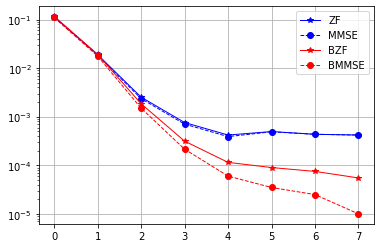

In [105]:
K = 2 
N = 16 
M = 4 
T = 100000
# dB scale
SNR_max = 30  
snr_single = 5 

constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
constellation_points /= np.sqrt(2) 

# make symbol space = |M|^K  in case of using ML detection 
symbol_space = make_symbol_space(K, M, cp=constellation_points) 

sers = []
sers_mmse = []
sers_bzf = []
sers_bmmse = []

for snr in range(-5, SNR_max+5, 5):
    x = np.random.randint(0, M, size=K * T).reshape(T, K, 1) 
    x = np.take(constellation_points, x)

    # Channel 
    H = (1 / np.sqrt(2)) * (np.random.randn(T, N, K) + 1j * np.random.randn(T, N, K))
    z = (1 / np.sqrt(2)) * (np.random.randn(T, N, 1) + 1j * np.random.randn(T, N, 1))

    r = np.matmul(H, x) + (10**(-snr/20)) * z 

    # Complex to real representation 
    H_re, x_re, z_re, r_re = comp2re(H, x, z, r) 

    # 1-bit ADC 
    y = np.sign(r_re) 
    y = y[:, :N, :] + 1j * y[:, N:, :]

    A, covn = bussgang(H, snr)

    # relaxed linear receiver 
    W_zf = np.linalg.pinv(H)
    W_mmse = np.matmul((H.conjugate()).transpose((0, 2, 1)), H) + (10**(-snr/20)) * ((np.eye(K)) * np.ones((T, K, K)))
    W_mmse = np.linalg.inv(W_mmse)
    W_mmse = np.matmul(W_mmse, (H.conjugate()).transpose((0, 2, 1)))
    W_bzf = np.linalg.pinv(A)
    W_bmmse = np.matmul(A, (A.conjugate()).transpose(0, 2, 1)) + covn 
    W_bmmse = np.linalg.inv(W_bmmse)
    W_bmmse = np.matmul((A.conjugate()).transpose(0, 2, 1), W_bmmse)
    # Relaxed estimation of x 

    x_tilde_zf = np.matmul(W_zf, y)
    x_tilde_mmse = np.matmul(W_mmse, y)
    x_tilde_bzf = np.matmul(W_bzf, y)
    x_tilde_bmmse = np.matmul(W_bmmse, y)
        
    # detection within each users (symbol-by-symbol)
    x_hat_zf = symbol_by_symbol(x_tilde=x_tilde_zf, constellation_points=constellation_points)
    x_hat_mmse = symbol_by_symbol(x_tilde=x_tilde_mmse, constellation_points=constellation_points) 
    x_hat_bzf = symbol_by_symbol(x_tilde=x_tilde_bzf, constellation_points=constellation_points)
    x_hat_bmmse = symbol_by_symbol(x_tilde=x_tilde_bmmse, constellation_points=constellation_points)

    # Compare 
    ser = 1-np.sum(np.isclose(x, x_hat_zf)) / (T * K)
    ser_mmse = 1-np.sum(np.isclose(x, x_hat_mmse)) / (T * K)
    ser_bzf = 1-np.sum(np.isclose(x, x_hat_bzf)) / (T * K)
    ser_bmmse = 1-np.sum(np.isclose(x, x_hat_bmmse)) / (T * K)

    if snr % 5 == 0:
        # print("snr: ", snr, "ser (zf): ", ser, "  |  ser(mmse): ", ser_mmse, "  |  ser(bzf):", ser_bzf)
        print(f"snr : {snr}  ser(bzf) : {ser_bzf:.3e}    |    ser(bmmse) : {ser_bmmse:.3e}")
    sers.append(ser)
    sers_mmse.append(ser_mmse)
    sers_bzf.append(ser_bzf)
    sers_bmmse.append(ser_bmmse)



plt.figure()
plt.semilogy(sers, '-b*', linewidth=1, label='ZF') 
plt.semilogy(sers_mmse, '--bo', linewidth=1, label='MMSE')
plt.semilogy(sers_bzf, '-r*', linewidth=1, label='BZF')
plt.semilogy(sers_bmmse, '--ro', linewidth=1, label="BMMSE")
plt.grid() 
plt.legend()
plt.show()



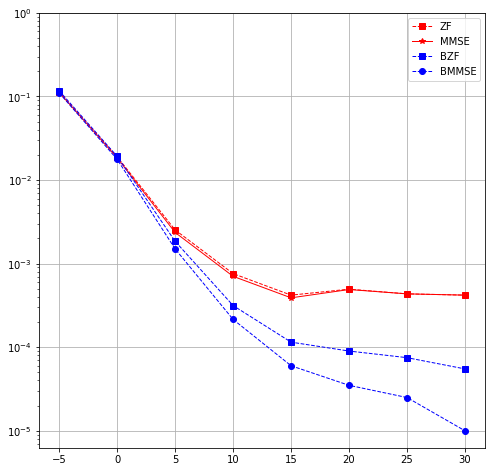

In [106]:

plt.figure(figsize=(8, 8))
plt.semilogy(range(-5, SNR_max+5, 5), sers, '--rs', linewidth=1, label='ZF')
plt.semilogy(range(-5, SNR_max+5, 5), sers_mmse, '-r*', linewidth=1, label='MMSE') 
plt.semilogy(range(-5, SNR_max+5, 5), sers_bzf, '--bs', linewidth=1, label='BZF')
plt.semilogy(range(-5, SNR_max+5, 5), sers_bmmse, '--bo', linewidth=1, label="BMMSE") 
plt.yticks([1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
plt.grid()
plt.legend()
plt.show()

In [117]:
sers_avg_bmmse = np.load('./results/sers_avg_bmmse.npy') 
sers_avg_bmmse

array([1.1023125e-01, 1.7140875e-02, 1.6575000e-03, 2.2775000e-04,
       6.2125000e-05, 2.9875000e-05, 2.5875000e-05, 1.5750000e-05])

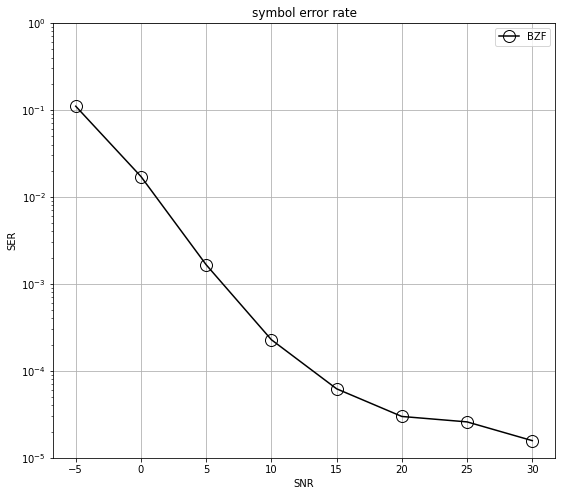

In [119]:

plt.figure(figsize=(9, 8))
plt.semilogy(np.arange(-5, 31, 5), sers_avg_bmmse, '-ko', label='BZF', markersize=12, fillstyle='none')

plt.grid()
plt.legend()
plt.xlabel("SNR")
plt.ylabel("SER")
plt.title("symbol error rate")
plt.yticks([1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
plt.show()

In [28]:
save_dir = './results/' 
np.save(save_dir+'sers_avg_ml.npy', sers_avg) 
